### Investigation into safety cars
In this notebook I want to investigate safety cars. My main question is whether the amount of safety cars can be modelled by using a poisson distribution. In order to do this I need to do the following things

1. Find safety cars in the data\
   Hypothesis: A safety car can be found by the following things
        - Increasing laptimes
        - No overtaking
        - Smaller time-difference between first and last driver
        - Smaller time-difference between all drivers
2. Look at their distribution.
    Find Lambda (expected per time interval)
        Investigate lambda, are there differences per track? Or year?
3. Comment on this, was Austria 2020 so strange?
    


In [1]:
## Imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from sklearn.linear_model import LinearRegression

# To get full output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#set random seed
random.seed(20)

In [2]:
# Change current working directory to where our F1 data is stored
os.getcwd();
os.chdir('C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science\\F1_data')
os.getcwd()  

'C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science'

'C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science\\F1_data'

We want to have the laptimes per round, so we need the laptimes dataset. 

In [3]:
laptimes_df = pd.read_csv('lap_times.csv')

In [4]:
laptimes_df.head()
laptimes_df.shape
laptimes_df.dtypes
laptimes_df.describe(include = 'all')
laptimes_df.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


(472504, 6)

raceId           int64
driverId         int64
lap              int64
position         int64
time            object
milliseconds     int64
dtype: object

,raceId,driverId,lap,position,time,milliseconds
count,472504.000000,472504.000000,472504.000000,472504.000000,472504,4.725040e+05
unique,NaN,NaN,NaN,NaN,70008,NaN
top,NaN,NaN,NaN,NaN,1:21.571,NaN
freq,NaN,NaN,NaN,NaN,36,NaN
mean,480.078222,229.773778,29.871804,9.651368,NaN,9.555486e+04
std,402.031351,345.382163,18.389696,5.562434,NaN,7.123219e+04
min,1.000000,1.000000,1.000000,1.000000,NaN,6.695700e+04
25%,112.000000,14.000000,14.000000,5.000000,NaN,8.223500e+04
50%,228.000000,30.000000,29.000000,9.000000,NaN,9.088100e+04
75%,911.000000,807.000000,44.000000,14.000000,NaN,1.026610e+05


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


#### Step 1. Find safetycars in the data
In order to find these in the data we have the following hypotheses
1. There are increasing laptimes
2. There is no overtaking
3. The time difference between the first and the last driver decreases

In [5]:
# Hypothesis 1. There are increasing laptimes
# Here we check the distribution of laptimes in a "normal" race
# I also want to know which race I'm looking at, so I'll add that info
races_df = pd.read_csv('races.csv')
races_df.head()
races_df.dtypes
races_df['race'] = races_df['name'] + ' ' + races_df['year'].astype(str)
races_df.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix


raceId        int64
year          int64
round         int64
circuitId     int64
name         object
date         object
time         object
url          object
dtype: object

,raceId,year,round,circuitId,name,date,time,url,race
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix,Australian Grand Prix 2009
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix,Malaysian Grand Prix 2009
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix,Chinese Grand Prix 2009
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix,Bahrain Grand Prix 2009
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix,Spanish Grand Prix 2009


In [6]:
# Here I'll get the mean time per lap
laptime_race_df = laptimes_df.merge(races_df[['raceId', 'race']]
                                    , how = 'left'
                                    , on = 'raceId')
laptime_race_df.head()
avg_laptimes_race_df = laptime_race_df[['raceId', 'lap', 'race','milliseconds',]]\
                                     .groupby(['raceId', 'lap'])\
                                     .agg({'milliseconds' : 'mean',
                                           'race'         : 'max'})
avg_laptimes_race_df = avg_laptimes_race_df.reset_index()
avg_laptimes_race_df.head()

,raceId,driverId,lap,position,time,milliseconds,race
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011


,raceId,lap,milliseconds,race
0,1,1,114684.421053,Australian Grand Prix 2009
1,1,2,94311.894737,Australian Grand Prix 2009
2,1,3,92195.842105,Australian Grand Prix 2009
3,1,4,91353.947368,Australian Grand Prix 2009
4,1,5,90935.947368,Australian Grand Prix 2009


Text(0.5, 1.0, 'average laptimes of Japanese Grand Prix 2016')

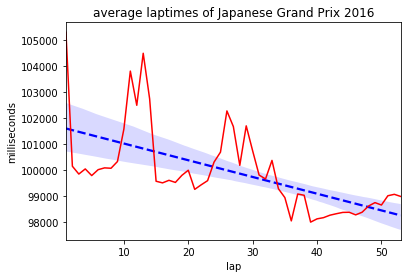

In [7]:
# Visualize the laptimes of an individual race
# Here we select a race to visualize
plot_raceID = random.choice(np.unique(avg_laptimes_race_df['raceId']))

sns.regplot(x = 'lap'
            , y = 'milliseconds'
            , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
            , scatter = False
            , line_kws={'color' : 'blue',
                       'ls' : '--'}
           )
sns.lineplot(x = 'lap'
            , y = 'milliseconds'
            , data = avg_laptimes_race_df[avg_laptimes_race_df['raceId'] == plot_raceID]
            , color = 'red')\
.set_title("average laptimes of {}".format(avg_laptimes_race_df['race'][avg_laptimes_race_df['raceId'] == plot_raceID].iloc[0]))

Text(0.5, 1.0, 'average laptimes of all races')

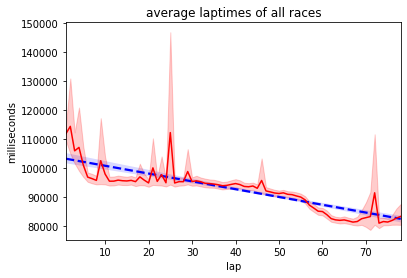

In [8]:
sns.regplot(x = 'lap'
            , y = 'milliseconds'
            , data = avg_laptimes_race_df
            , scatter = False
            , line_kws={'color' : 'blue',
                       'ls' : '--'}
           )
sns.lineplot(x = 'lap'
            , y = 'milliseconds'
            , data = avg_laptimes_race_df
            , color = 'red')\
.set_title("average laptimes of all races")

In [9]:
# From this plot we can see that most of the times the laptimes
# should be going down
# we will check with a regression whether that is indeed the case
# Here X will be the lapnumber, and Y will be the laptime
X = avg_laptimes_race_df[['lap']]
y = avg_laptimes_race_df[['milliseconds']]
reg = LinearRegression().fit(X, y)
print('Every lap is on average {0:.2f}ms faster than the previous'.format(reg.coef_[0][0]))

Every lap is on average -269.25ms faster than the previous


In [10]:
# Thus, we can see that the laptime should be going down with each lap
# Based on this info we can see that someting is going on if this is not the case
# We will make an indicator for this, indicating whether the lap was faster than the previous
avg_laptimes_race_df['previous_round'] = avg_laptimes_race_df.groupby('raceId')['milliseconds'].shift()

avg_laptimes_race_df['faster_previous'] = np.where(avg_laptimes_race_df['milliseconds'] < avg_laptimes_race_df['previous_round']
                                                   , True
                                                   , False)
avg_laptimes_race_df.head(100)

,raceId,lap,milliseconds,race,previous_round,faster_previous
0,1,1,114684.421053,Australian Grand Prix 2009,NaN,False
1,1,2,94311.894737,Australian Grand Prix 2009,114684.421053,True
2,1,3,92195.842105,Australian Grand Prix 2009,94311.894737,True
3,1,4,91353.947368,Australian Grand Prix 2009,92195.842105,True
4,1,5,90935.947368,Australian Grand Prix 2009,91353.947368,True
5,1,6,90785.368421,Australian Grand Prix 2009,90935.947368,True
6,1,7,90608.842105,Australian Grand Prix 2009,90785.368421,True
7,1,8,90957.789474,Australian Grand Prix 2009,90608.842105,False
8,1,9,92478.368421,Australian Grand Prix 2009,90957.789474,False
9,1,10,94215.578947,Australian Grand Prix 2009,92478.368421,False


We now have an indicator to show whether this lap was faster than the previous lap. However, there are multiple reasons why a lap can be slower. Such as: pit-stops, rain, traffic etc.
Therefore we want to have more conditions, and we will continue with our next hypothesis:
There will be no overtaking during a safety-car

#### How to find this
We can find this by taking a look at the position of a driver during the race, and comparing it to the round before. If it's the same then the driver was not overtaken or did not overtake.

Text(0.5, 1.0, 'Changes in position during Australian Grand Prix 2011')

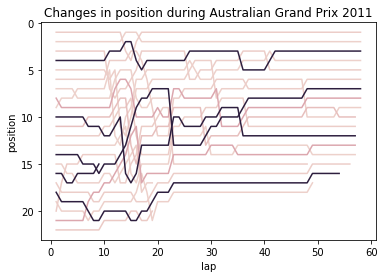

In [11]:
# First we will take a look at the position of drivers during a race
ax = sns.lineplot(x = 'lap', y = 'position', hue = 'driverId', data = laptime_race_df[(laptime_race_df['raceId'] == 841)])
ax.set_title("Changes in position during {}".format(laptime_race_df['race'][laptime_race_df['raceId'] == 841].iloc[0]))
ax.invert_yaxis()
ax.legend_.remove()

In [12]:
# From here we can see that there are some times when there are many changes (pit-stops)
# We will now make an indicator to see if someone was overtaken
laptime_race_df.head()
laptime_race_df['position_previous_round'] = laptime_race_df.groupby(['raceId', 'driverId'])['position'].shift()
laptime_race_df['overtake'] = np.where(laptime_race_df['position'] < laptime_race_df['position_previous_round']
                                       , True
                                       , False)  
laptime_race_df.head(100)


,raceId,driverId,lap,position,time,milliseconds,race
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011


,raceId,driverId,lap,position,time,milliseconds,race,position_previous_round,overtake
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,NaN,False
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,1.0,False
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,1.0,False
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,1.0,False
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,1.0,False
5,841,20,6,1,1:32.605,92605,Australian Grand Prix 2011,1.0,False
6,841,20,7,1,1:32.502,92502,Australian Grand Prix 2011,1.0,False
7,841,20,8,1,1:32.537,92537,Australian Grand Prix 2011,1.0,False
8,841,20,9,1,1:33.240,93240,Australian Grand Prix 2011,1.0,False
9,841,20,10,1,1:32.572,92572,Australian Grand Prix 2011,1.0,False


In [13]:
# We now have an indicator per driver if they did an overtake.
# However, we want to know per lap of the race if there was an overtake
overtake_df = laptime_race_df[['raceId', 'lap','overtake',]]\
                                     .groupby(['raceId', 'lap'])\
                                     .max()\
                                     .reset_index() 

overtake_df.head(100)

,raceId,lap,overtake
0,1,1,False
1,1,2,True
2,1,3,True
3,1,4,True
4,1,5,True
5,1,6,True
6,1,7,False
7,1,8,False
8,1,9,False
9,1,10,True


16068     1
16071     4
16089    22
16091    24
16100    33
16101    34
16105    38
16106    39
16107    40
16110    43
16111    44
16112    45
16113    46
16114    47
16117    50
16118    51
16119    52
16120    53
16122    55
16123    56
16124    57
16125    58
Name: lap, dtype: int64

Text(0.5, 1.0, 'Changes in position during Australian Grand Prix 2011')

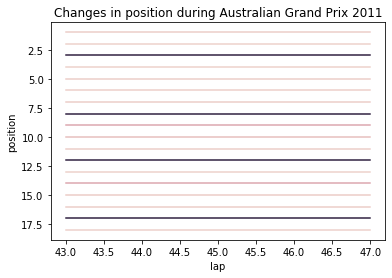

In [14]:
# To check if this works the way we want to we check the results with the graph
overtake_df['lap'][(overtake_df['overtake'] == False) & (overtake_df['raceId'] == 841)]

# It seems there were no overtakes in lap 43 to 47
no_overtake_laps_df = laptime_race_df[(laptime_race_df['lap'] >= 43) 
                                   & (laptime_race_df['lap'] <= 47) 
                                   & (laptime_race_df['raceId'] == 841)]

ax = sns.lineplot(x = 'lap', y = 'position', hue = 'driverId', data = no_overtake_laps_df)
ax.set_title("Changes in position during {}".format(laptime_race_df['race'][laptime_race_df['raceId'] == 841].iloc[0]))
ax.invert_yaxis()
ax.legend_.remove()

# We only see straight lines so indeed no overtakes
# I checked and there was no safety car during this period

In [15]:
# We join this to our initial df
avg_laptimes_race_df = avg_laptimes_race_df.merge(overtake_df[['raceId'
                                                               , 'lap'
                                                               , 'overtake']]
                                    , how = 'left'
                                    , on = ['raceId', 'lap'])
avg_laptimes_race_df.head()

,raceId,lap,milliseconds,race,previous_round,faster_previous,overtake
0,1,1,114684.421053,Australian Grand Prix 2009,NaN,False,False
1,1,2,94311.894737,Australian Grand Prix 2009,114684.421053,True,True
2,1,3,92195.842105,Australian Grand Prix 2009,94311.894737,True,True
3,1,4,91353.947368,Australian Grand Prix 2009,92195.842105,True,True
4,1,5,90935.947368,Australian Grand Prix 2009,91353.947368,True,True


We now have our second indicator finished, whether there was overtaking. We will continue with working on our next indicator. There will be a decrease in time between the first and last driver.

In order to do this I want to create a cumulative sum of the laptimes per driver per race
This can then be used to calculate the difference to the driver in first position

In [63]:
# we will use laptime_race_df again
laptime_race_df.head()

,raceId,driverId,lap,position,time,milliseconds,race,position_previous_round,overtake
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,NaN,False
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,1.0,False
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,1.0,False
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,1.0,False
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,1.0,False


In [71]:
laptime_race_df = laptime_race_df.merge(laptime_race_df[['raceId', 'driverId', 'lap', 'milliseconds']]\
                            .groupby(by = ['raceId', 'driverId', 'lap']) \
                            .sum() \
                            .groupby(level = [0,1]) \
                            .cumsum() \
                            .reset_index()
                            .rename(columns = {'milliseconds' : 'cumulative_time'})
                        , how = 'left'
                        , on = ['raceId', 'driverId', 'lap']
                       ) 
           
laptime_race_df.head()


,raceId,driverId,lap,position,time,milliseconds,race,position_previous_round,overtake,cumulative_time
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011,NaN,False,98109
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011,1.0,False,191115
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011,1.0,False,283828
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011,1.0,False,376631
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011,1.0,False,468973


In [215]:
laptime_race_df = laptime_race_df.merge(laptime_race_df[['raceId', 'lap', 'position', 'driverId', 'cumulative_time']]\
                            .sort_values(['raceId'
                                            , 'lap'
                                            , 'position']
                                        , ascending = True)\
                            .set_index(['raceId', 'lap', 'driverId'])\
                            .groupby(['raceId', 'lap']) \
                            .diff() \
                            .groupby(['raceId', 'lap']) \
                            .cumsum() \
                            .fillna(0) \
                            .reset_index() \
                            .rename(columns = {'cumulative_time' : 'ms_difference_P1'})
                        , how = 'left'
                        , on = ['raceId', 'driverId', 'lap']
                       )\
                .drop('position_y', axis = 'columns') \
                .rename(columns = {'position_x' : 'position'})


laptime_race_df.sort_values(['raceId'
                , 'lap'
                , 'position']
                , ascending = True).head(5)


,raceId,driverId,lap,position,time,milliseconds,race,position_previous_round,overtake,cumulative_time
448879,1010,822,1,1,1:33.813,93813,Australian Grand Prix 2019,NaN,False,93813
448937,1010,1,1,2,1:34.887,94887,Australian Grand Prix 2019,NaN,False,94887
448995,1010,20,1,3,1:35.626,95626,Australian Grand Prix 2019,NaN,False,95626
449053,1010,830,1,4,1:36.291,96291,Australian Grand Prix 2019,NaN,False,96291
449111,1010,844,1,5,1:37.042,97042,Australian Grand Prix 2019,NaN,False,97042


,raceId,driverId,lap,position,time,milliseconds,race,position_previous_round,overtake,cumulative_time,ms_difference_P1
343770,1,18,1,1,1:35.652,95652,Australian Grand Prix 2009,NaN,False,95652,0.0
343523,1,20,1,2,1:39.647,99647,Australian Grand Prix 2009,NaN,False,99647,3995.0
342939,1,13,1,3,1:40.201,100201,Australian Grand Prix 2009,NaN,False,100201,4549.0
343039,1,9,1,4,1:41.250,101250,Australian Grand Prix 2009,NaN,False,101250,5598.0
342984,1,8,1,5,1:41.712,101712,Australian Grand Prix 2009,NaN,False,101712,6060.0


Text(0.5, 1.0, 'Changes in position during Australian Grand Prix 2011')

,raceId,driverId,lap,position,time,milliseconds,race,position_previous_round,overtake,cumulative_time,ms_difference_P1
713,841,2,57,14,1:35.088,95088,Australian Grand Prix 2011,14.0,False,5443901,165588.0
57,841,20,58,1,1:31.946,91946,Australian Grand Prix 2011,1.0,False,5370259,0.0
115,841,1,58,2,1:34.576,94576,Australian Grand Prix 2011,2.0,False,5392556,22297.0
231,841,808,58,3,1:30.767,90767,Australian Grand Prix 2011,3.0,False,5400819,30560.0
485,841,4,58,4,1:30.501,90501,Australian Grand Prix 2011,4.0,False,5402031,31772.0
173,841,17,58,5,1:32.279,92279,Australian Grand Prix 2011,5.0,False,5408430,38171.0
347,841,18,58,6,1:31.203,91203,Australian Grand Prix 2011,6.0,False,5424563,54304.0
771,841,815,58,7,1:32.577,92577,Australian Grand Prix 2011,7.0,False,5436104,65845.0
427,841,155,58,8,1:31.830,91830,Australian Grand Prix 2011,8.0,False,5447131,76872.0
289,841,13,58,9,1:31.822,91822,Australian Grand Prix 2011,9.0,False,5455445,85186.0


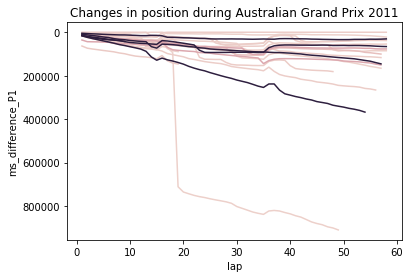

In [219]:
#  We seem to have a working solution
#  We will now try to visualize to understand if all is going how it should go
test_df = laptime_race_df[laptime_race_df['raceId'] == 841]
# It seems to work
ax = sns.lineplot(x = 'lap', y = 'ms_difference_P1', hue = 'driverId', data = test_df)
ax.set_title("Changes in position during {}".format(laptime_race_df['race'][laptime_race_df['raceId'] == 841].iloc[0]))
ax.invert_yaxis()
ax.legend_.remove()

test_df.sort_values(by = ['lap', 'position']).tail(10)
# We also checked the results of this race online. It all works the way it should

Now that we now the difference between the drivers we want to know whether the times decrease between the P1 driver and the others. We can reuse our earlier code to check if that is the case